<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/pytorch/CGAN_CIFAR10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN (Conditional GAN), Cifar10

In [0]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [0]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint
import cv2

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 100
cfg.INPUT_MODE = None
cfg.INPUT_CMAP = None

cfg.OUTPUT_HEIGHT = 32
cfg.OUTPUT_WIDTH = 32
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None # pyplot cmap


cfg.G_DIM = 32
cfg.D_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'CGAN_CIFAR10'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 128
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.BCELoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 4
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['airplane',
                 'automobile',
                 'bird',
                 'cat',
                 'deer',
                 'dog',
                 'frog',
                 'horse',
                 'ship',
                 'truck'],
 'CLASS_NUM': 10,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'D_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CMAP': None,
 'INPUT_MODE': None,
 'INPUT_Z_DIM': 100,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_CMAP': None,
 'OUTPUT_HEIGHT': 32,
 'OUTPUT_MODE': 'RGB',
 'OUTPUT_WIDTH': 32,
 'PREFIX': 'CGAN_CIFAR10',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 4,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/CGAN_CIFAR10_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/CGAN_CIFAR10_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
   

## Define Model

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM + cfg.CLASS_NUM, cfg.G_DIM * 8, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'G_layer_1_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 8, cfg.G_DIM * 4, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_2_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_3_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_4' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_4_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_4_ReLU' : torch.nn.ReLU(inplace=True),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL + cfg.CLASS_NUM, cfg.D_DIM, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_2_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_3_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 4),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_4' : torch.nn.Conv2d(cfg.D_DIM * 4, cfg.D_DIM * 8, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_4_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'D_layer_4_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 8, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], padding=0, stride=1, bias=False),
            'D_layer_out_sigmoid' : torch.nn.Sigmoid()
        }))

    def forward(self, x):
        return self.module(x)

## Utility

In [0]:
def result_show(G, Xs, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    Gz = G(Xs)
    Gz = Gz.detach().cpu().numpy()
    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    
    if cfg.OUTPUT_CHANNEL == 1:
        Gz = Gz[:, 0]
    else:
        Gz = Gz.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(Gz))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show output
        _G = Gz[i]

        plt.subplot(1, show_max, i + 1)
        plt.imshow(_G, cmap=cmap_out)
        plt.axis('off')
        plt.title(cfg.CLASS_LABEL[i ])

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

#---
# preprocess for torchvision.datasets
#---
def preprocess(Xs, cfg, mode, hf=False, vf=False, rot=False):
    xs = []

    for x in Xs:
        # resize
        x = cv2.resize(x, (cfg.OUTPUT_WIDTH, cfg.OUTPUT_HEIGHT)).astype(np.float32)
        
        # channel BGR -> Gray
        if mode == 'GRAY':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = np.expand_dims(x, axis=-1)
        elif mode == 'EDGE':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = cv2.Canny(x, 100, 150)
            x = np.expand_dims(x, axis=-1)

        # horizontal flip
        if hf and np.random.rand() < 0.5:
            x = x[:, ::-1]

        # vertical flip
        if vf and np.random.rand() < 0.5:
            x = x[::-1]

        # rotation
        if rot != False:
            rot = np.random.randint(0, 360, 1) // cfg.TRAIN.DATA_ROTATION * cfg.TRAIN.DATA_ROTATION

            scale = 1

            _h, _w = x.shape[:2]
            _c = 1
            if len(x.shape) == 3:
                _c = x.shape[2]

            max_side = max(_h, _w)
            tmp = np.zeros((max_side, max_side, _c))
            tx = int((max_side - _w) / 2)
            ty = int((max_side - _h) / 2)
            tmp[ty: ty+_h, tx: tx+_w] = x.copy()
            M = cv2.getRotationMatrix2D((max_side / 2, max_side / 2), rot, scale)
            _x = cv2.warpAffine(tmp, M, (max_side, max_side))
            x = _x[tx:tx+_w, ty:ty+_h]

        if mode == 'CLASS_LABEL':
            _x = x
            x = np.zeros((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.CLASS_NUM), dtype=np.int)

            for i, (_, vs) in enumerate(cfg.CLASS_LABEL.items()):
                ind = (_x[..., 0] == vs[0]) * (_x[..., 1] == vs[1]) * (_x[..., 2] == vs[2])
                x[..., i][ind] = 1

        else:
            # normalization [0, 255] -> [-1, 1]
            x = x / 127.5 - 1

            # channel BGR -> RGB
            #if mode in ['RGB']:
            #    x = x[..., ::-1]

        xs.append(x)
                
    xs = np.array(xs, dtype=np.float32)
    if cfg.CHANNEL_AXIS == 1:
        if len(xs.shape) == 4:
            xs = xs.transpose(0, 3, 1, 2)
        else:
            xs = np.expand_dims(xs, axis=1)
    else:
        if len(xs.shape) == 3:
            xs = np.expand_dims(xs, axis=-1)

    return xs

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 2, 2]         112,640
       BatchNorm2d-2            [-1, 256, 2, 2]             512
              ReLU-3            [-1, 256, 2, 2]               0
   ConvTranspose2d-4            [-1, 128, 4, 4]         524,288
       BatchNorm2d-5            [-1, 128, 4, 4]             256
              ReLU-6            [-1, 128, 4, 4]               0
   ConvTranspose2d-7             [-1, 64, 8, 8]         131,072
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
  ConvTranspose2d-10           [-1, 32, 16, 16]          32,768
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]           1,536
             Tanh-14            [-1, 3,

Extracting ./data/cifar-10-python.tar.gz to ./data/
training start
Iter:50, LossG (fake:5.5500), LossD:0.1030 (real:0.0526, fake:0.0505)
Iter:100, LossG (fake:8.0670), LossD:0.7023 (real:0.0097, fake:0.6926)
Iter:150, LossG (fake:3.5127), LossD:0.9822 (real:0.4315, fake:0.5506)
Iter:200, LossG (fake:3.2468), LossD:0.6363 (real:0.3031, fake:0.3331)
save G >> models/CGAN_CIFAR10_G_iter200.pt, D >> models/CGAN_CIFAR10_D_iter200.pt
Iter:250, LossG (fake:3.2549), LossD:0.5696 (real:0.2878, fake:0.2819)
Iter:300, LossG (fake:4.1236), LossD:0.4757 (real:0.2855, fake:0.1902)
Iter:350, LossG (fake:4.1407), LossD:0.5186 (real:0.2343, fake:0.2843)
Iter:400, LossG (fake:3.0470), LossD:0.6335 (real:0.4611, fake:0.1724)
save G >> models/CGAN_CIFAR10_G_iter400.pt, D >> models/CGAN_CIFAR10_D_iter400.pt
Iter:450, LossG (fake:1.9912), LossD:0.8389 (real:0.5366, fake:0.3022)
Iter:500, LossG (fake:2.0922), LossD:0.9972 (real:0.8121, fake:0.1851)
result was saved to >> result/CGAN_CIFAR10_result_iter500.jp

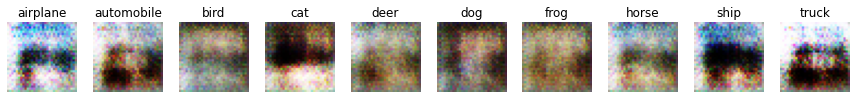

Iter:550, LossG (fake:3.3710), LossD:0.8150 (real:0.7496, fake:0.0654)
Iter:600, LossG (fake:2.5765), LossD:0.5591 (real:0.4137, fake:0.1454)
save G >> models/CGAN_CIFAR10_G_iter600.pt, D >> models/CGAN_CIFAR10_D_iter600.pt
Iter:650, LossG (fake:3.6590), LossD:1.0696 (real:0.4229, fake:0.6467)
Iter:700, LossG (fake:3.1282), LossD:0.7593 (real:0.5774, fake:0.1819)
Iter:750, LossG (fake:2.1816), LossD:0.7443 (real:0.5027, fake:0.2416)
Iter:800, LossG (fake:4.8179), LossD:0.6782 (real:0.0878, fake:0.5903)
save G >> models/CGAN_CIFAR10_G_iter800.pt, D >> models/CGAN_CIFAR10_D_iter800.pt
Iter:850, LossG (fake:2.9030), LossD:0.5896 (real:0.4415, fake:0.1481)
Iter:900, LossG (fake:2.2736), LossD:0.9208 (real:0.8378, fake:0.0830)
Iter:950, LossG (fake:2.4674), LossD:1.0370 (real:0.7792, fake:0.2578)
Iter:1000, LossG (fake:4.6778), LossD:0.4375 (real:0.2097, fake:0.2278)
save G >> models/CGAN_CIFAR10_G_iter1000.pt, D >> models/CGAN_CIFAR10_D_iter1000.pt
result was saved to >> result/CGAN_CIFAR1

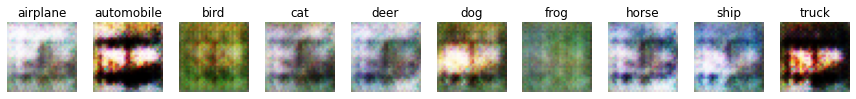

Iter:1050, LossG (fake:5.0385), LossD:0.8191 (real:0.2047, fake:0.6144)
Iter:1100, LossG (fake:3.1131), LossD:0.5128 (real:0.3033, fake:0.2095)
Iter:1150, LossG (fake:3.6640), LossD:0.6427 (real:0.4875, fake:0.1553)
Iter:1200, LossG (fake:3.0138), LossD:0.4832 (real:0.3118, fake:0.1714)
save G >> models/CGAN_CIFAR10_G_iter1200.pt, D >> models/CGAN_CIFAR10_D_iter1200.pt
Iter:1250, LossG (fake:4.5027), LossD:0.9857 (real:0.9770, fake:0.0087)
Iter:1300, LossG (fake:3.4181), LossD:0.9273 (real:0.5225, fake:0.4048)
Iter:1350, LossG (fake:3.0883), LossD:0.4811 (real:0.3612, fake:0.1199)
Iter:1400, LossG (fake:1.9222), LossD:1.0812 (real:0.8260, fake:0.2553)
save G >> models/CGAN_CIFAR10_G_iter1400.pt, D >> models/CGAN_CIFAR10_D_iter1400.pt
Iter:1450, LossG (fake:4.0654), LossD:1.4758 (real:0.2647, fake:1.2111)
Iter:1500, LossG (fake:4.6414), LossD:0.7116 (real:0.2301, fake:0.4815)
result was saved to >> result/CGAN_CIFAR10_result_iter1500.jpg


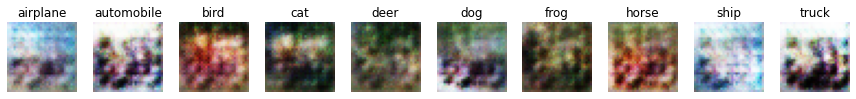

Iter:1550, LossG (fake:2.7109), LossD:0.6166 (real:0.2263, fake:0.3902)
Iter:1600, LossG (fake:4.6525), LossD:1.1193 (real:0.1899, fake:0.9294)
save G >> models/CGAN_CIFAR10_G_iter1600.pt, D >> models/CGAN_CIFAR10_D_iter1600.pt
Iter:1650, LossG (fake:2.9519), LossD:1.1855 (real:0.7094, fake:0.4761)
Iter:1700, LossG (fake:3.6930), LossD:0.3664 (real:0.2982, fake:0.0681)
Iter:1750, LossG (fake:1.1871), LossD:1.3930 (real:1.1813, fake:0.2118)
Iter:1800, LossG (fake:2.2799), LossD:0.9094 (real:0.7078, fake:0.2016)
save G >> models/CGAN_CIFAR10_G_iter1800.pt, D >> models/CGAN_CIFAR10_D_iter1800.pt
Iter:1850, LossG (fake:2.5715), LossD:0.8053 (real:0.4483, fake:0.3570)
Iter:1900, LossG (fake:2.4385), LossD:0.9703 (real:0.8311, fake:0.1392)
Iter:1950, LossG (fake:2.8239), LossD:0.4302 (real:0.2517, fake:0.1785)
Iter:2000, LossG (fake:3.9295), LossD:0.7847 (real:0.2006, fake:0.5841)
save G >> models/CGAN_CIFAR10_G_iter2000.pt, D >> models/CGAN_CIFAR10_D_iter2000.pt
result was saved to >> resul

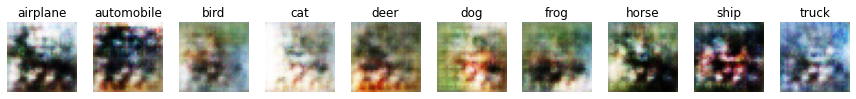

Iter:2050, LossG (fake:2.4581), LossD:1.0071 (real:0.6733, fake:0.3338)
Iter:2100, LossG (fake:2.3387), LossD:0.5896 (real:0.3665, fake:0.2231)
Iter:2150, LossG (fake:1.9003), LossD:0.8121 (real:0.5810, fake:0.2311)
Iter:2200, LossG (fake:1.7755), LossD:1.3015 (real:1.1380, fake:0.1635)
save G >> models/CGAN_CIFAR10_G_iter2200.pt, D >> models/CGAN_CIFAR10_D_iter2200.pt
Iter:2250, LossG (fake:2.7705), LossD:0.8899 (real:0.5397, fake:0.3501)
Iter:2300, LossG (fake:1.8346), LossD:0.8009 (real:0.5639, fake:0.2370)
Iter:2350, LossG (fake:4.5473), LossD:0.9228 (real:0.1516, fake:0.7712)
Iter:2400, LossG (fake:2.8859), LossD:0.6205 (real:0.4843, fake:0.1362)
save G >> models/CGAN_CIFAR10_G_iter2400.pt, D >> models/CGAN_CIFAR10_D_iter2400.pt
Iter:2450, LossG (fake:3.3291), LossD:0.9709 (real:0.2930, fake:0.6779)
Iter:2500, LossG (fake:1.0068), LossD:1.4301 (real:1.3464, fake:0.0836)
result was saved to >> result/CGAN_CIFAR10_result_iter2500.jpg


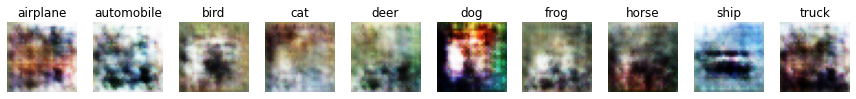

Iter:2550, LossG (fake:2.8878), LossD:0.6789 (real:0.2956, fake:0.3833)
Iter:2600, LossG (fake:3.9311), LossD:1.3292 (real:0.1217, fake:1.2075)
save G >> models/CGAN_CIFAR10_G_iter2600.pt, D >> models/CGAN_CIFAR10_D_iter2600.pt
Iter:2650, LossG (fake:1.8960), LossD:0.8564 (real:0.6706, fake:0.1858)
Iter:2700, LossG (fake:2.5578), LossD:0.9822 (real:0.8712, fake:0.1110)
Iter:2750, LossG (fake:2.2310), LossD:0.7139 (real:0.4307, fake:0.2833)
Iter:2800, LossG (fake:2.8309), LossD:0.8621 (real:0.6839, fake:0.1782)
save G >> models/CGAN_CIFAR10_G_iter2800.pt, D >> models/CGAN_CIFAR10_D_iter2800.pt
Iter:2850, LossG (fake:3.0323), LossD:0.8792 (real:0.2392, fake:0.6400)
Iter:2900, LossG (fake:2.8814), LossD:1.0770 (real:0.3839, fake:0.6930)
Iter:2950, LossG (fake:3.3987), LossD:1.0120 (real:0.3324, fake:0.6796)
Iter:3000, LossG (fake:3.0740), LossD:0.7920 (real:0.4466, fake:0.3454)
save G >> models/CGAN_CIFAR10_G_iter3000.pt, D >> models/CGAN_CIFAR10_D_iter3000.pt
result was saved to >> resul

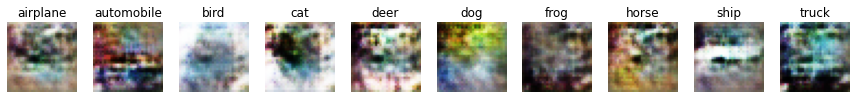

Iter:3050, LossG (fake:3.2156), LossD:0.5718 (real:0.2562, fake:0.3156)
Iter:3100, LossG (fake:4.0393), LossD:0.6511 (real:0.1993, fake:0.4518)
Iter:3150, LossG (fake:2.5325), LossD:0.9702 (real:0.5346, fake:0.4356)
Iter:3200, LossG (fake:1.7949), LossD:0.7649 (real:0.4406, fake:0.3243)
save G >> models/CGAN_CIFAR10_G_iter3200.pt, D >> models/CGAN_CIFAR10_D_iter3200.pt
Iter:3250, LossG (fake:3.4844), LossD:0.5100 (real:0.1657, fake:0.3443)
Iter:3300, LossG (fake:2.4629), LossD:0.9519 (real:0.5567, fake:0.3952)
Iter:3350, LossG (fake:2.6377), LossD:0.8015 (real:0.6649, fake:0.1366)
Iter:3400, LossG (fake:3.5553), LossD:0.8024 (real:0.1939, fake:0.6085)
save G >> models/CGAN_CIFAR10_G_iter3400.pt, D >> models/CGAN_CIFAR10_D_iter3400.pt
Iter:3450, LossG (fake:2.4605), LossD:0.9499 (real:0.6046, fake:0.3454)
Iter:3500, LossG (fake:4.0223), LossD:0.7544 (real:0.1522, fake:0.6022)
result was saved to >> result/CGAN_CIFAR10_result_iter3500.jpg


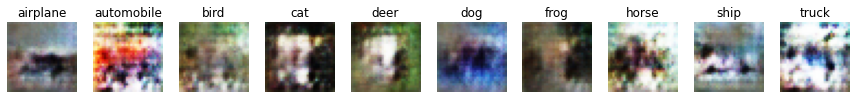

Iter:3550, LossG (fake:1.9412), LossD:1.4356 (real:1.3023, fake:0.1333)
Iter:3600, LossG (fake:4.3878), LossD:1.0620 (real:0.1762, fake:0.8858)
save G >> models/CGAN_CIFAR10_G_iter3600.pt, D >> models/CGAN_CIFAR10_D_iter3600.pt
Iter:3650, LossG (fake:3.6654), LossD:1.0240 (real:0.2842, fake:0.7398)
Iter:3700, LossG (fake:4.8829), LossD:1.2174 (real:0.0915, fake:1.1259)
Iter:3750, LossG (fake:4.0658), LossD:0.7298 (real:0.1739, fake:0.5558)
Iter:3800, LossG (fake:2.3366), LossD:0.8984 (real:0.5898, fake:0.3086)
save G >> models/CGAN_CIFAR10_G_iter3800.pt, D >> models/CGAN_CIFAR10_D_iter3800.pt
Iter:3850, LossG (fake:3.1924), LossD:0.9641 (real:0.3297, fake:0.6344)
Iter:3900, LossG (fake:3.2188), LossD:0.7549 (real:0.2314, fake:0.5235)
Iter:3950, LossG (fake:1.7360), LossD:0.8659 (real:0.6761, fake:0.1898)
Iter:4000, LossG (fake:2.5462), LossD:0.6700 (real:0.4353, fake:0.2347)
save G >> models/CGAN_CIFAR10_G_iter4000.pt, D >> models/CGAN_CIFAR10_D_iter4000.pt
result was saved to >> resul

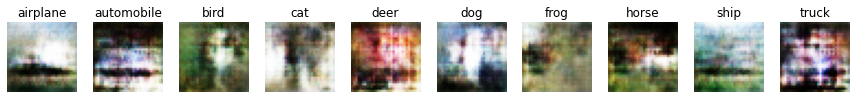

Iter:4050, LossG (fake:3.3234), LossD:0.7802 (real:0.1840, fake:0.5962)
Iter:4100, LossG (fake:3.1312), LossD:0.7124 (real:0.3122, fake:0.4002)
Iter:4150, LossG (fake:2.8862), LossD:0.8469 (real:0.3156, fake:0.5313)
Iter:4200, LossG (fake:2.5829), LossD:0.7853 (real:0.7089, fake:0.0764)
save G >> models/CGAN_CIFAR10_G_iter4200.pt, D >> models/CGAN_CIFAR10_D_iter4200.pt
Iter:4250, LossG (fake:4.1201), LossD:1.1157 (real:0.0879, fake:1.0278)
Iter:4300, LossG (fake:2.8178), LossD:0.7647 (real:0.2397, fake:0.5250)
Iter:4350, LossG (fake:2.1389), LossD:0.8103 (real:0.6138, fake:0.1965)
Iter:4400, LossG (fake:3.3774), LossD:0.6436 (real:0.3151, fake:0.3285)
save G >> models/CGAN_CIFAR10_G_iter4400.pt, D >> models/CGAN_CIFAR10_D_iter4400.pt
Iter:4450, LossG (fake:3.3999), LossD:0.5817 (real:0.1403, fake:0.4414)
Iter:4500, LossG (fake:3.0759), LossD:0.7304 (real:0.2572, fake:0.4732)
result was saved to >> result/CGAN_CIFAR10_result_iter4500.jpg


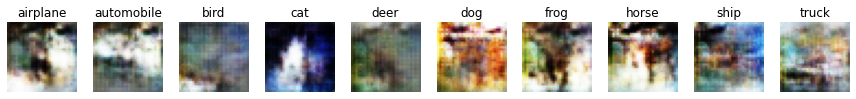

Iter:4550, LossG (fake:3.8475), LossD:0.5660 (real:0.1855, fake:0.3805)
Iter:4600, LossG (fake:3.7750), LossD:0.8884 (real:0.1787, fake:0.7097)
save G >> models/CGAN_CIFAR10_G_iter4600.pt, D >> models/CGAN_CIFAR10_D_iter4600.pt
Iter:4650, LossG (fake:2.4908), LossD:1.0187 (real:0.3110, fake:0.7076)
Iter:4700, LossG (fake:1.7802), LossD:0.6260 (real:0.4642, fake:0.1618)
Iter:4750, LossG (fake:3.9206), LossD:0.3489 (real:0.1253, fake:0.2236)
Iter:4800, LossG (fake:2.0543), LossD:0.8763 (real:0.7576, fake:0.1187)
save G >> models/CGAN_CIFAR10_G_iter4800.pt, D >> models/CGAN_CIFAR10_D_iter4800.pt
Iter:4850, LossG (fake:2.3777), LossD:0.6032 (real:0.4180, fake:0.1852)
Iter:4900, LossG (fake:4.0016), LossD:0.7162 (real:0.2365, fake:0.4797)
Iter:4950, LossG (fake:2.5818), LossD:0.7562 (real:0.3715, fake:0.3847)
Iter:5000, LossG (fake:3.7528), LossD:1.1461 (real:0.1334, fake:1.0127)
save G >> models/CGAN_CIFAR10_G_iter5000.pt, D >> models/CGAN_CIFAR10_D_iter5000.pt
result was saved to >> resul

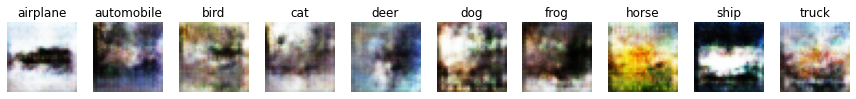

Iter:5050, LossG (fake:2.9095), LossD:0.8725 (real:0.3158, fake:0.5566)
Iter:5100, LossG (fake:3.4823), LossD:0.9374 (real:0.1364, fake:0.8010)
Iter:5150, LossG (fake:3.9221), LossD:1.4486 (real:0.0604, fake:1.3882)
Iter:5200, LossG (fake:1.6315), LossD:1.1465 (real:0.9884, fake:0.1582)
save G >> models/CGAN_CIFAR10_G_iter5200.pt, D >> models/CGAN_CIFAR10_D_iter5200.pt
Iter:5250, LossG (fake:3.8916), LossD:0.6519 (real:0.2749, fake:0.3770)
Iter:5300, LossG (fake:3.8563), LossD:0.8854 (real:0.2431, fake:0.6423)
Iter:5350, LossG (fake:2.7206), LossD:0.9672 (real:0.3260, fake:0.6412)
Iter:5400, LossG (fake:1.8895), LossD:1.0242 (real:0.6061, fake:0.4181)
save G >> models/CGAN_CIFAR10_G_iter5400.pt, D >> models/CGAN_CIFAR10_D_iter5400.pt
Iter:5450, LossG (fake:1.8643), LossD:0.9013 (real:0.7537, fake:0.1476)
Iter:5500, LossG (fake:1.6633), LossD:1.2096 (real:0.9613, fake:0.2483)
result was saved to >> result/CGAN_CIFAR10_result_iter5500.jpg


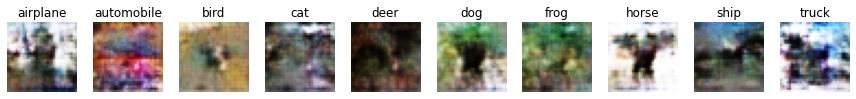

Iter:5550, LossG (fake:3.3116), LossD:0.8764 (real:0.0987, fake:0.7777)
Iter:5600, LossG (fake:1.9403), LossD:0.6938 (real:0.5903, fake:0.1035)
save G >> models/CGAN_CIFAR10_G_iter5600.pt, D >> models/CGAN_CIFAR10_D_iter5600.pt
Iter:5650, LossG (fake:3.8773), LossD:0.3639 (real:0.2773, fake:0.0866)
Iter:5700, LossG (fake:2.6247), LossD:1.1277 (real:0.3172, fake:0.8106)
Iter:5750, LossG (fake:2.0289), LossD:1.1874 (real:0.8758, fake:0.3117)
Iter:5800, LossG (fake:4.8959), LossD:0.6662 (real:0.1446, fake:0.5216)
save G >> models/CGAN_CIFAR10_G_iter5800.pt, D >> models/CGAN_CIFAR10_D_iter5800.pt
Iter:5850, LossG (fake:3.4044), LossD:0.5177 (real:0.1081, fake:0.4096)
Iter:5900, LossG (fake:0.9285), LossD:1.2381 (real:1.1414, fake:0.0968)
Iter:5950, LossG (fake:3.3911), LossD:0.7590 (real:0.3243, fake:0.4347)
Iter:6000, LossG (fake:3.6752), LossD:0.8360 (real:0.1741, fake:0.6619)
save G >> models/CGAN_CIFAR10_G_iter6000.pt, D >> models/CGAN_CIFAR10_D_iter6000.pt
result was saved to >> resul

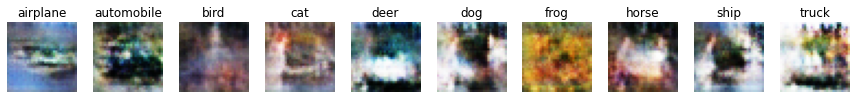

Iter:6050, LossG (fake:4.3731), LossD:0.6353 (real:0.1081, fake:0.5271)
Iter:6100, LossG (fake:0.8512), LossD:0.9145 (real:0.7797, fake:0.1348)
Iter:6150, LossG (fake:3.1006), LossD:0.9848 (real:0.1764, fake:0.8084)
Iter:6200, LossG (fake:4.0023), LossD:0.7865 (real:0.1994, fake:0.5872)
save G >> models/CGAN_CIFAR10_G_iter6200.pt, D >> models/CGAN_CIFAR10_D_iter6200.pt
Iter:6250, LossG (fake:2.4371), LossD:1.5315 (real:0.1843, fake:1.3472)
Iter:6300, LossG (fake:3.2521), LossD:1.4625 (real:0.1581, fake:1.3044)
Iter:6350, LossG (fake:4.4819), LossD:1.1188 (real:0.1075, fake:1.0113)
Iter:6400, LossG (fake:2.0232), LossD:1.0054 (real:0.8943, fake:0.1111)
save G >> models/CGAN_CIFAR10_G_iter6400.pt, D >> models/CGAN_CIFAR10_D_iter6400.pt
Iter:6450, LossG (fake:2.0166), LossD:0.6764 (real:0.3952, fake:0.2811)
Iter:6500, LossG (fake:1.9004), LossD:0.9032 (real:0.5634, fake:0.3399)
result was saved to >> result/CGAN_CIFAR10_result_iter6500.jpg


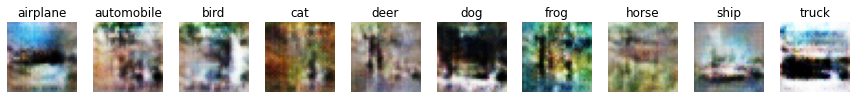

Iter:6550, LossG (fake:1.0140), LossD:1.0500 (real:0.9211, fake:0.1289)
Iter:6600, LossG (fake:3.1388), LossD:0.6682 (real:0.4548, fake:0.2134)
save G >> models/CGAN_CIFAR10_G_iter6600.pt, D >> models/CGAN_CIFAR10_D_iter6600.pt
Iter:6650, LossG (fake:3.7816), LossD:0.5928 (real:0.1424, fake:0.4504)
Iter:6700, LossG (fake:0.7497), LossD:1.0913 (real:0.9197, fake:0.1716)
Iter:6750, LossG (fake:3.1300), LossD:0.4191 (real:0.3254, fake:0.0937)
Iter:6800, LossG (fake:1.9196), LossD:0.7581 (real:0.6519, fake:0.1063)
save G >> models/CGAN_CIFAR10_G_iter6800.pt, D >> models/CGAN_CIFAR10_D_iter6800.pt
Iter:6850, LossG (fake:4.1083), LossD:0.9530 (real:0.1243, fake:0.8286)
Iter:6900, LossG (fake:3.1355), LossD:0.4928 (real:0.3571, fake:0.1357)
Iter:6950, LossG (fake:1.5837), LossD:1.5587 (real:1.3915, fake:0.1672)
Iter:7000, LossG (fake:3.4294), LossD:1.0088 (real:0.1956, fake:0.8132)
save G >> models/CGAN_CIFAR10_G_iter7000.pt, D >> models/CGAN_CIFAR10_D_iter7000.pt
result was saved to >> resul

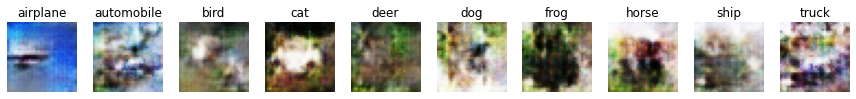

Iter:7050, LossG (fake:3.7686), LossD:0.4250 (real:0.2063, fake:0.2187)
Iter:7100, LossG (fake:4.1124), LossD:0.7241 (real:0.1391, fake:0.5850)
Iter:7150, LossG (fake:2.8874), LossD:0.6346 (real:0.4151, fake:0.2195)
Iter:7200, LossG (fake:3.8092), LossD:0.8804 (real:0.1906, fake:0.6897)
save G >> models/CGAN_CIFAR10_G_iter7200.pt, D >> models/CGAN_CIFAR10_D_iter7200.pt
Iter:7250, LossG (fake:0.8781), LossD:0.8325 (real:0.7437, fake:0.0888)
Iter:7300, LossG (fake:2.9062), LossD:0.8806 (real:0.5318, fake:0.3488)
Iter:7350, LossG (fake:2.7222), LossD:0.8118 (real:0.2703, fake:0.5416)
Iter:7400, LossG (fake:1.7124), LossD:0.8631 (real:0.5742, fake:0.2889)
save G >> models/CGAN_CIFAR10_G_iter7400.pt, D >> models/CGAN_CIFAR10_D_iter7400.pt
Iter:7450, LossG (fake:3.9323), LossD:0.4867 (real:0.0812, fake:0.4055)
Iter:7500, LossG (fake:1.9214), LossD:0.9577 (real:0.1815, fake:0.7762)
result was saved to >> result/CGAN_CIFAR10_result_iter7500.jpg


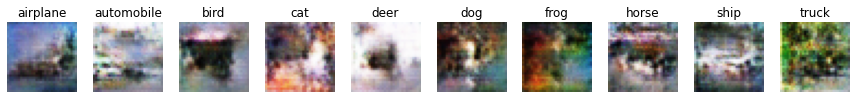

Iter:7550, LossG (fake:1.6537), LossD:0.7605 (real:0.4968, fake:0.2637)
Iter:7600, LossG (fake:2.1857), LossD:0.9661 (real:0.8939, fake:0.0722)
save G >> models/CGAN_CIFAR10_G_iter7600.pt, D >> models/CGAN_CIFAR10_D_iter7600.pt
Iter:7650, LossG (fake:1.9986), LossD:0.9613 (real:0.8372, fake:0.1241)
Iter:7700, LossG (fake:2.2297), LossD:0.8786 (real:0.3956, fake:0.4830)
Iter:7750, LossG (fake:1.7932), LossD:1.0447 (real:0.5322, fake:0.5125)
Iter:7800, LossG (fake:1.3899), LossD:1.0374 (real:0.8260, fake:0.2114)
save G >> models/CGAN_CIFAR10_G_iter7800.pt, D >> models/CGAN_CIFAR10_D_iter7800.pt
Iter:7850, LossG (fake:3.8684), LossD:1.1381 (real:0.2219, fake:0.9162)
Iter:7900, LossG (fake:1.1636), LossD:0.8929 (real:0.7075, fake:0.1854)
Iter:7950, LossG (fake:1.9706), LossD:0.6696 (real:0.4350, fake:0.2346)
Iter:8000, LossG (fake:1.0993), LossD:0.7456 (real:0.5346, fake:0.2110)
save G >> models/CGAN_CIFAR10_G_iter8000.pt, D >> models/CGAN_CIFAR10_D_iter8000.pt
result was saved to >> resul

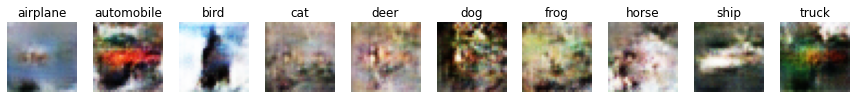

Iter:8050, LossG (fake:2.9798), LossD:0.7881 (real:0.2715, fake:0.5165)
Iter:8100, LossG (fake:2.8323), LossD:0.8150 (real:0.2684, fake:0.5466)
Iter:8150, LossG (fake:4.1236), LossD:0.8689 (real:0.0754, fake:0.7935)
Iter:8200, LossG (fake:2.7787), LossD:1.5050 (real:0.2004, fake:1.3046)
save G >> models/CGAN_CIFAR10_G_iter8200.pt, D >> models/CGAN_CIFAR10_D_iter8200.pt
Iter:8250, LossG (fake:2.3411), LossD:0.8463 (real:0.3880, fake:0.4583)
Iter:8300, LossG (fake:1.1772), LossD:0.6966 (real:0.4077, fake:0.2889)
Iter:8350, LossG (fake:2.7606), LossD:0.5328 (real:0.3209, fake:0.2120)
Iter:8400, LossG (fake:1.6587), LossD:0.9332 (real:0.8794, fake:0.0538)
save G >> models/CGAN_CIFAR10_G_iter8400.pt, D >> models/CGAN_CIFAR10_D_iter8400.pt
Iter:8450, LossG (fake:2.1667), LossD:0.7027 (real:0.1686, fake:0.5341)
Iter:8500, LossG (fake:2.7988), LossD:1.0128 (real:0.4209, fake:0.5919)
result was saved to >> result/CGAN_CIFAR10_result_iter8500.jpg


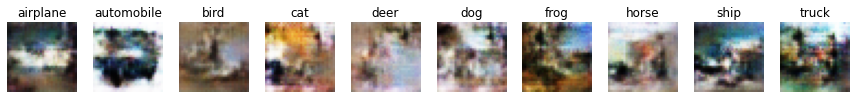

Iter:8550, LossG (fake:1.8370), LossD:0.7379 (real:0.4145, fake:0.3234)
Iter:8600, LossG (fake:2.5813), LossD:0.7209 (real:0.2836, fake:0.4373)
save G >> models/CGAN_CIFAR10_G_iter8600.pt, D >> models/CGAN_CIFAR10_D_iter8600.pt
Iter:8650, LossG (fake:2.1215), LossD:0.7370 (real:0.3852, fake:0.3518)
Iter:8700, LossG (fake:1.3880), LossD:0.9554 (real:0.7812, fake:0.1742)
Iter:8750, LossG (fake:1.6920), LossD:0.9080 (real:0.6795, fake:0.2285)
Iter:8800, LossG (fake:1.8545), LossD:0.7534 (real:0.5920, fake:0.1614)
save G >> models/CGAN_CIFAR10_G_iter8800.pt, D >> models/CGAN_CIFAR10_D_iter8800.pt
Iter:8850, LossG (fake:2.8247), LossD:0.7348 (real:0.3569, fake:0.3779)
Iter:8900, LossG (fake:3.9717), LossD:1.1362 (real:0.1740, fake:0.9623)
Iter:8950, LossG (fake:4.1519), LossD:0.7760 (real:0.1041, fake:0.6720)
Iter:9000, LossG (fake:1.8619), LossD:0.7669 (real:0.6970, fake:0.0698)
save G >> models/CGAN_CIFAR10_G_iter9000.pt, D >> models/CGAN_CIFAR10_D_iter9000.pt
result was saved to >> resul

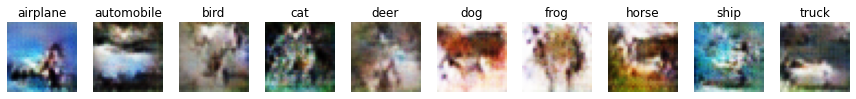

Iter:9050, LossG (fake:2.9084), LossD:0.8977 (real:0.3704, fake:0.5274)
Iter:9100, LossG (fake:3.1048), LossD:1.1435 (real:0.2539, fake:0.8896)
Iter:9150, LossG (fake:1.1399), LossD:0.8761 (real:0.6651, fake:0.2110)
Iter:9200, LossG (fake:2.8337), LossD:0.4821 (real:0.2241, fake:0.2580)
save G >> models/CGAN_CIFAR10_G_iter9200.pt, D >> models/CGAN_CIFAR10_D_iter9200.pt
Iter:9250, LossG (fake:3.1323), LossD:0.6234 (real:0.1851, fake:0.4383)
Iter:9300, LossG (fake:2.0570), LossD:1.1588 (real:0.9421, fake:0.2167)
Iter:9350, LossG (fake:3.3361), LossD:1.0943 (real:0.2006, fake:0.8937)
Iter:9400, LossG (fake:0.6875), LossD:1.2110 (real:1.0929, fake:0.1181)
save G >> models/CGAN_CIFAR10_G_iter9400.pt, D >> models/CGAN_CIFAR10_D_iter9400.pt
Iter:9450, LossG (fake:0.3936), LossD:1.5976 (real:1.4815, fake:0.1161)
Iter:9500, LossG (fake:2.7749), LossD:0.8025 (real:0.2785, fake:0.5239)
result was saved to >> result/CGAN_CIFAR10_result_iter9500.jpg


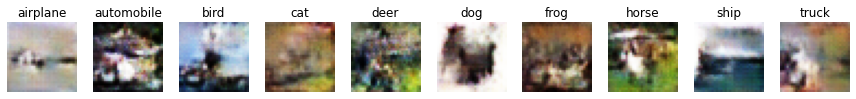

Iter:9550, LossG (fake:1.4861), LossD:1.0314 (real:0.8600, fake:0.1714)
Iter:9600, LossG (fake:2.2346), LossD:1.2143 (real:0.4747, fake:0.7396)
save G >> models/CGAN_CIFAR10_G_iter9600.pt, D >> models/CGAN_CIFAR10_D_iter9600.pt
Iter:9650, LossG (fake:1.4874), LossD:0.9456 (real:0.6369, fake:0.3087)
Iter:9700, LossG (fake:2.4828), LossD:0.8342 (real:0.5487, fake:0.2855)
Iter:9750, LossG (fake:2.8746), LossD:1.3852 (real:0.3259, fake:1.0593)
Iter:9800, LossG (fake:1.7152), LossD:0.7612 (real:0.5240, fake:0.2372)
save G >> models/CGAN_CIFAR10_G_iter9800.pt, D >> models/CGAN_CIFAR10_D_iter9800.pt
Iter:9850, LossG (fake:3.6947), LossD:1.1800 (real:0.1095, fake:1.0705)
Iter:9900, LossG (fake:3.3172), LossD:1.1013 (real:0.2136, fake:0.8877)
Iter:9950, LossG (fake:1.8623), LossD:0.7101 (real:0.5469, fake:0.1633)
Iter:10000, LossG (fake:0.9356), LossD:1.5718 (real:1.4601, fake:0.1118)
save G >> models/CGAN_CIFAR10_G_iter10000.pt, D >> models/CGAN_CIFAR10_D_iter10000.pt
result was saved to >> re

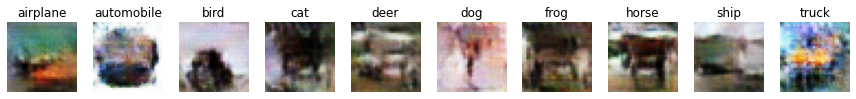

final paramters were saved to G >> models/CGAN_CIFAR10_G_final.pt, D >> models/CGAN_CIFAR10_D_final.pt
loss was saved to >> result/CGAN_CIFAR10_loss.csv


In [7]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    summary(G, (cfg.INPUT_Z_DIM + cfg.CLASS_NUM, 1, 1), device=cfg.DEVICE_TYPE)
    summary(D, (cfg.OUTPUT_CHANNEL + cfg.CLASS_NUM, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = np.array(trainset.data)
    train_ys = np.array(trainset.targets)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ys = train_ys[mb_ind]
        
        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        
        #  add conditional
        z_con = torch.zeros([cfg.TRAIN.MINIBATCH, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
        z_con[range(cfg.TRAIN.MINIBATCH), ys] = 1
        z = torch.cat([z, z_con], dim=1)

        # forward
        Gz = G(z)
        #Gz = torch.reshape(Gz, [cfg.TRAIN.MINIBATCH, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])

        #  add conditional
        Gz_con = torch.zeros([cfg.TRAIN.MINIBATCH, cfg.CLASS_NUM, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH], dtype=torch.float).to(cfg.DEVICE)
        Gz_con[range(cfg.TRAIN.MINIBATCH), ys] = 1
        Gz = torch.cat([Gz, Gz_con], dim=1)
        
        Xs = torch.cat([Xs, Gz_con], dim=1)
        
        D_real = D(Xs)[..., 0, 0, 0]
        D_fake = D(Gz)[..., 0, 0, 0]

        # update D
        loss_D_real = cfg.TRAIN.LOSS_FUNCTION(D_real, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D_fake = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.zeros(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        opt_D.step()

        # update G
        opt_G.zero_grad()
        Gz = G(z)
        Gz = torch.cat([Gz, Gz_con], dim=1)
        D_fake = D(Gz)[..., 0, 0, 0]
        loss_G = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_G.backward()
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.CLASS_NUM, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            #  add conditional
            z_con = torch.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
            z_con[range(cfg.CLASS_NUM), range(cfg.CLASS_NUM)] = 1
            z = torch.cat([z, z_con], dim=1)
            
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)


    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------


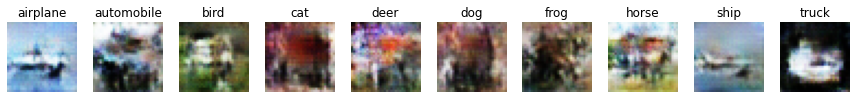

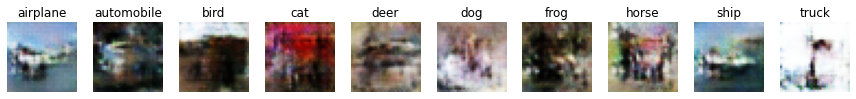

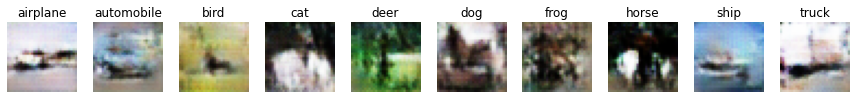

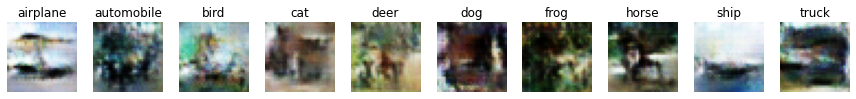

In [8]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.CLASS_NUM, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        #  add conditional
        z_con = torch.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
        z_con[range(cfg.CLASS_NUM), range(cfg.CLASS_NUM)] = 1
        z = torch.cat([z, z_con], dim=1)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE,
                    show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
